In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import numpy as np
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
NAME = 'for_generator_korean_folium(3_label)'
TRAIN_DATA_DIR = f'../../data/{NAME}/train'
VALIDATION_DATA_DIR = f'../../data/{NAME}/val'
TEST_DATA_DIR = f'../../data/{NAME}/test'
 
TRAIN_SAMPLES = 15926
VALIDATION_SAMPLES = 1990
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 64
EPOCH = 100

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                                   rotation_range=45,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   zoom_range=0.3,
                                   vertical_flip =True,
                                   horizontal_flip =True)
 
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
 
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 15926 images belonging to 3 classes.
Found 1990 images belonging to 3 classes.


학습

In [4]:
def model_maker(num_class, input_shape=(224, 224, 3)):
    # model = VGG16(weights='imagenet', include_top=True)
    base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
    print(len(base_model.layers))
 
    # for layer in base_model.layers[:]:
        # layer.trainable = False
    for layer in base_model.layers[:130]:
        print('freeze: ', layer.name , str(layer.trainable))
        layer.trainable = False 
 
    input = tf.keras.Input(shape=input_shape)
    custom_model = base_model(input)
    custom_model = tf.keras.layers.GlobalAveragePooling2D()(custom_model)
    custom_model = tf.keras.layers.Dropout(0.2)(custom_model)
    custom_model = tf.keras.layers.Dense(32, activation='relu')(custom_model)
    predictions = tf.keras.layers.Dense(num_class, activation='softmax')(custom_model)
    
    return tf.keras.Model(inputs=input, outputs=predictions)
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      tf.keras.metrics.CategoricalAccuracy(name='accuracy')
]
model_final = model_maker(3, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model_final.summary()
model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=METRICS)

154
freeze:  input_1 True
freeze:  Conv1 True
freeze:  bn_Conv1 True
freeze:  Conv1_relu True
freeze:  expanded_conv_depthwise True
freeze:  expanded_conv_depthwise_BN True
freeze:  expanded_conv_depthwise_relu True
freeze:  expanded_conv_project True
freeze:  expanded_conv_project_BN True
freeze:  block_1_expand True
freeze:  block_1_expand_BN True
freeze:  block_1_expand_relu True
freeze:  block_1_pad True
freeze:  block_1_depthwise True
freeze:  block_1_depthwise_BN True
freeze:  block_1_depthwise_relu True
freeze:  block_1_project True
freeze:  block_1_project_BN True
freeze:  block_2_expand True
freeze:  block_2_expand_BN True
freeze:  block_2_expand_relu True
freeze:  block_2_depthwise True
freeze:  block_2_depthwise_BN True
freeze:  block_2_depthwise_relu True
freeze:  block_2_project True
freeze:  block_2_project_BN True
freeze:  block_2_add True
freeze:  block_3_expand True
freeze:  block_3_expand_BN True
freeze:  block_3_expand_relu True
freeze:  block_3_pad True
freeze:  blo

In [5]:
checkpoint_path = f"./{NAME}_MobileNet40/cp-{EPOCH:04d}.ckpt"   # 3
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True)

import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

class_weights = dict(enumerate(class_weights))

history = model_final.fit(
    train_generator,
    steps_per_epoch=TRAIN_SAMPLES // (BATCH_SIZE), # number of updates
    epochs=EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_SAMPLES // (BATCH_SIZE),
    callbacks=[cp_callback ],
    class_weight=class_weights,
    workers=11)

Epoch 1/100
247/248 [============================>.] - ETA: 0s - loss: 0.9943 - tp: 5984.0000 - fp: 4106.0000 - tn: 27490.0000 - fn: 9814.0000 - precision: 0.5931 - recall: 0.3788 - auc: 0.7232 - prc: 0.5992 - accuracy: 0.5210
Epoch 1: val_accuracy improved from -inf to 0.55948, saving model to ./for_generator_korean_folium(3_label)_MobileNet40\cp-0100.ckpt
248/248 [==============================] - 30s 94ms/step - loss: 0.9943 - tp: 6013.0000 - fp: 4117.0000 - tn: 27607.0000 - fn: 9849.0000 - precision: 0.5936 - recall: 0.3791 - auc: 0.7233 - prc: 0.5995 - accuracy: 0.5214 - val_loss: 0.9838 - val_tp: 979.0000 - val_fp: 683.0000 - val_tn: 3285.0000 - val_fn: 1005.0000 - val_precision: 0.5890 - val_recall: 0.4934 - val_auc: 0.7430 - val_prc: 0.6217 - val_accuracy: 0.5595
Epoch 2/100
247/248 [============================>.] - ETA: 0s - loss: 0.9027 - tp: 6251.0000 - fp: 3340.0000 - tn: 28256.0000 - fn: 9547.0000 - precision: 0.6518 - recall: 0.3957 - auc: 0.7698 - prc: 0.6580 - accuracy

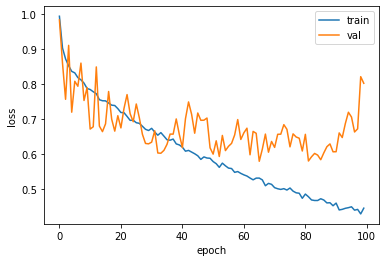

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

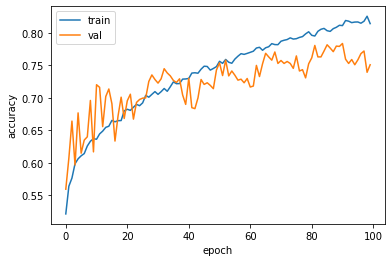

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

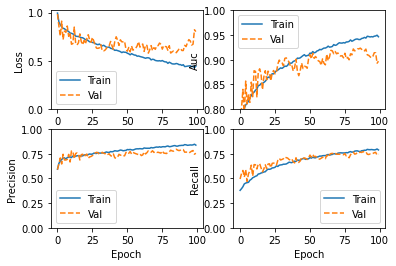

In [8]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
plot_metrics(history)

In [9]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
 
test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 1997 images belonging to 3 classes.


In [10]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model_final.load_weights(latest)

model_final.evaluate(test_generator, steps=VALIDATION_SAMPLES // BATCH_SIZE)


31/31 [==============================] - 4s 116ms/step - loss: 0.6350 - tp: 1515.0000 - fp: 422.0000 - tn: 3546.0000 - fn: 469.0000 - precision: 0.7821 - recall: 0.7636 - auc: 0.9188 - prc: 0.8632 - accuracy: 0.7717


[0.6349722146987915,
 1515.0,
 422.0,
 3546.0,
 469.0,
 0.7821373343467712,
 0.7636088728904724,
 0.9188439249992371,
 0.8632229566574097,
 0.7716733813285828]

In [11]:
model_final.save(f'./{NAME}_MobileNet40.h5')
model_final.save(f'./{NAME}_MobileNet40/MobileNet')

INFO:tensorflow:Assets written to: ./for_generator_korean_folium(3_label)_MobileNet40/MobileNet\assets


INFO:tensorflow:Assets written to: ./for_generator_korean_folium(3_label)_MobileNet40/MobileNet\assets
